In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math 
import collections
import openpyxl
import matplotlib.pyplot as plt
import io
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import pypsa



network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H')
network.set_snapshots(hours_in_2015)
network.add("Bus","electricity bus")
#print(network.snapshots) 


# load electricity demand data
df_elec = pd.read_csv('time_series_60min_singleindex.csv', sep=',', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
#print(df_elec['GB_GBN_wind_generation_actual'].head())

# add load to the bus
network.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['GB_GBN_load_actual_entsoe_transparency'])


print(network.loads_t.p_set)

def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

# add the different carriers, only gas emits CO2
network.add("Carrier", "onshorewind") # in t_CO2/MWh_th
network.add("Carrier", "offshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "gas", co2_emissions=0.185)

# add onshore wind generator
df_onshorewind = pd.read_csv('onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind['GBR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]] #https://www.grantthornton.co.uk/globalassets/1.-member-firms/united-kingdom/pdf/documents/renewable-energy-discount-rate-survey-results-2018.pdf
#CF_wind = np.load("CF_wind_2011.npy") #used for part c
#np.save("CF_wind_2011.npy",CF_wind) #used for part c
capital_cost_onshorewind = annuity(25,0.08)*52910*(1) # in €/MW  https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/911817/electricity-generation-cost-report-2020.pdf
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind)

# add offshore wind generator
df_offshorewind = pd.read_csv('offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
CF_wind_offshore = df_offshorewind['GBR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
#CF_wind_offshore = np.load("CF_wind_offshore_2011.npy") #used for part c
#np.save("CF_wind_offshore_2011.npy",CF_wind_offshore) #used for part c
capital_cost_offshorewind = annuity(25,0.0875)*65560*(1) # in €/MW 910000
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore)

# add solar PV generator
df_solar = pd.read_csv('pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar['GBR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
#CF_solar = np.load("CF_solar_2011.npy")
#np.save("CF_solar_2011.npy",CF_solar)

capital_cost_solar = annuity(25,0.07)*50610*(1) # in €/MW 
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar)



# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*930700*(1) # in €/MW #https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/315717/coal_and_gas_assumptions.PDF
fuel_cost = 14.71 # in €/MWh_th #https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1107499/quarterly_energy_prices_uk_september_2022.pdf
efficiency = 0.38 #https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/387566/Technical_Assessment_of_the_Operation_of_Coal_and_Gas_Plant_PB_Power_FIN....pdf
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator", 
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

network.lopf(network.snapshots, 
             pyomo=False,
             solver_name='gurobi')

#print((network.objective/network.loads_t.p.sum())) # €/MWh
print (network.generators_t.p_max_pu) # in MW

Load                          load
snapshot                          
2015-01-01 00:00:00+00:00  26758.0
2015-01-01 01:00:00+00:00  27166.0
2015-01-01 02:00:00+00:00  24472.0
2015-01-01 03:00:00+00:00  23003.0
2015-01-01 04:00:00+00:00  21832.0
...                            ...
2015-12-31 19:00:00+00:00  42578.0
2015-12-31 20:00:00+00:00  39838.0
2015-12-31 21:00:00+00:00  37250.0
2015-12-31 22:00:00+00:00  35843.0
2015-12-31 23:00:00+00:00  34020.0

[8760 rows x 1 columns]
8760


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.57s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-28
Read LP format model from file C:\Users\RAWADF~1\AppData\Local\Temp\pypsa-problem-_atlxqfk.lp
Reading time = 0.59 seconds
obj: 78840 rows, 35045 columns, 135914 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 78840 rows, 35045 columns and 135914 nonzeros
Model fingerprint: 0xa904e019
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+03, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 39298 rows and 4256 columns
Presolve time: 0.31s
Presolved: 39542 rows, 30789 columns, 92355 nonzeros

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 6.157e+04
 Factor NZ  : 2.513e+05 (roughly 30 MB of memory)
 Factor Ops : 1.68

INFO:pypsa.linopf:Optimization successful. Objective value: 5.99e+09


Generator                  onshorewind  offshorewind  solar
snapshot                                                   
2015-01-01 00:00:00+00:00        0.606         0.601    0.0
2015-01-01 01:00:00+00:00        0.610         0.569    0.0
2015-01-01 02:00:00+00:00        0.592         0.538    0.0
2015-01-01 03:00:00+00:00        0.570         0.539    0.0
2015-01-01 04:00:00+00:00        0.552         0.561    0.0
...                                ...           ...    ...
2015-12-31 19:00:00+00:00        0.508         0.735    0.0
2015-12-31 20:00:00+00:00        0.426         0.666    0.0
2015-12-31 21:00:00+00:00        0.336         0.554    0.0
2015-12-31 22:00:00+00:00        0.282         0.462    0.0
2015-12-31 23:00:00+00:00        0.256         0.400    0.0

[8760 rows x 3 columns]


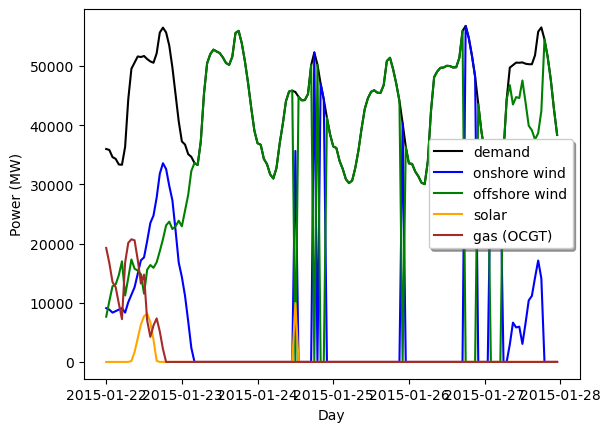

In [2]:
#Week 4 Plot
plt.plot(network.loads_t.p['load'][504:648], color='black', label='demand') #5040:5136 504:648
plt.plot(network.generators_t.p['onshorewind'][504:648], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['offshorewind'][504:648], color='green', label='offshore wind')
plt.plot(network.generators_t.p['solar'][504:648], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][504:648], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.xlabel('Day') 
plt.ylabel('Power (MW)') 
plt.show()

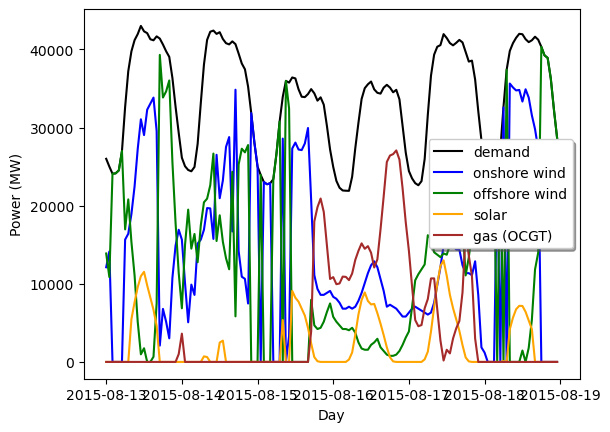

In [7]:
#Week 33 plot
plt.plot(network.loads_t.p['load'][5376:5520], color='black', label='demand') 
plt.plot(network.generators_t.p['onshorewind'][5376:5520], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['offshorewind'][5376:5520], color='green', label='offshore wind')
plt.plot(network.generators_t.p['solar'][5376:5520], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][5376:5520], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.xlabel('Day') 
plt.ylabel('Power (MW)') 
plt.show()

In [8]:
print ((network.generators.p_nom_opt)/1000) # in GW

Generator
onshorewind     252.508135
offshorewind    155.970432
solar            21.964207
OCGT             38.632552
Name: p_nom_opt, dtype: float64


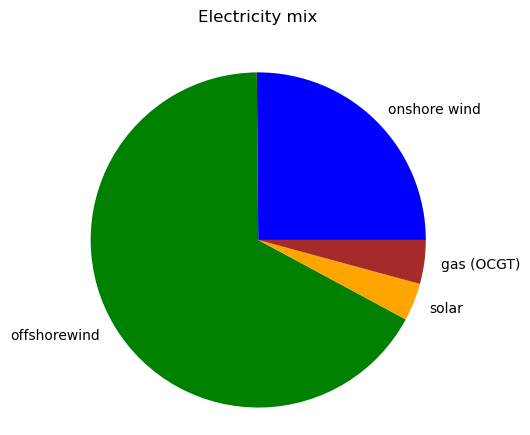

In [9]:
labels = ['onshore wind','offshorewind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]


colors = ['blue', 'green', 'orange','brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)
plt.show()